In [1]:
###########################################################################                                                                         #
# Responsible for pre-processing sensor data and building, training, &    #
# evaluating the model.                                                   #
#                                                                         #
# required input:                                                         #
###########################################################################

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import math

from keras.optimizers import SGD
from keras.models import Sequential, Model
from keras.layers import Dense,BatchNormalization,LSTM,Input,Flatten
from keras.callbacks import Callback

from sklearn.preprocessing import MinMaxScaler, StandardScaler, scale
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
    
PROGRAMMATIC = True

###########################################################################
# A callback to give us the r-squared value for our models predictions    #
# during training.                                                        #
###########################################################################

class R2Callback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        X_test, y_test = self.test_data
        pred = self.model.predict(X_test)
        r2 = r2_score(pred,y_test)
        print('r2 score: {},\n'.format(r2))



/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
num_attributes=11
num_targets=3

In [24]:
###########################################################################                                                                         #
# Responsible for forcing Keras run on CPU.                               #
#                                                                         #
# required input:                                                         #
###########################################################################



import tensorflow as tf
from keras import backend as K

num_cores = 4
num_CPU = 1
num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
session = tf.Session(config=config)
K.set_session(session)

In [25]:

######################################################################################
#                             getData()                                              #
# Get the data out of the files and in a nice format.                                #
# Parameters:                                                                        #
#     files : a list of files with the data in it                                    #
#     debug : a debug flag.                                                          #
######################################################################################

def getData(files,debug):

    data    = np.empty((0,num_attributes)) #initializing empty array with proper shape
    targets = np.empty((0,num_targets   )) #empty array for targets
    batches = np.array([])

    for f in files:
        print(f)
        #grab the relative pathname and we can save the data for later.
        relative_path = f[f.rfind('/')+1:]

        full_data = np.loadtxt(f,delimiter = ',')

        ###########################################################
        # The first three columns are targets, the rest features, #
        # and we're predicting the difference in each feature     #
        # from one time point to the next.                        #
        ###########################################################

        processed_data    = full_data
        processed_targets = full_data[1:,:3]-full_data[:-1,:3]

        batch = processed_data.shape[0]

        if debug :
            print("full_data.shape: {}".format(full_data.shape))
            print("processed_data.shape: {}".format(processed_data.shape))
            print("processed_target.shape: {}".format(processed_targets.shape))

        data    = np.append(data, processed_data, axis=0)
        targets = np.append(targets, processed_targets, axis=0)
        batches = np.append(batches,[batch])

        np.savetxt('Data/Processed/' + relative_path, processed_data, delimiter=',', fmt = '%f')
    scalar_train = MinMaxScaler()
    scalar_train = scalar_train.fit(data)
    data = scalar_train.transform(data)
    scalar_targets = MinMaxScaler()
    scalar_targets = scalar_targets.fit(targets)
    targets= scalar_targets.transform(targets)
    
    if debug :
        print("data[0:10]: \n{}".format(data[0:10]))
        print("targets[0:10]: \n{}".format(targets[0:10]))
        print("batches: \n{}".format(batches))
    return data,targets,batches



In [26]:

######################################################################################
#                             split_array()                                          #
# splits data into chunks , each array will be of same sizest.                       #
# Parameters:                                                                        #
#     files : a list of files with the data in it                                    #
#     debug : a debug flag.                                                          #
######################################################################################


def split_array(x,split_size=8,final_shape=8,test_only=False):
    counter = 0
    block = list();
    temp = list();
    print(x.shape)
    for i in range(0,x.shape[0]):
        block.append(x[i])
        counter = counter + 1
        if counter == split_size:
            block_list = list();
            for i in range(0,final_shape):
                block_list.append(block[-1])
            block = np.array(block_list)
            block = np.resize(block_list,(final_shape,final_shape))
            temp.append(block)
            counter = 0
            block = list();
    return np.array(temp)
        
        

In [27]:
files=["/home/crumpler/DMproject-master/Data/Clean/layton_1.1.csv"]

In [49]:

###########################################################################                                                                         #
# Splits the data to image slice and generats mask required by the symbol #
#  branch                                                                 #
#                                                                         #
###########################################################################
data,targets,samples = getData(files,True)
print(targets.shape)
data = split_array(data,8)
data = np.array(data)
targets = split_array(targets,8,8)
last_value = targets[:,7,:]
last_value = last_value[:,0:3]
targets = np.array(targets)
data =data.reshape((data.shape[0],data.shape[1],data.shape[2],1))
targets =targets.reshape((targets.shape[0],targets.shape[1],targets.shape[2],1))
targets_mask = np.ma.masked_where(targets >0, targets).mask
print(data.shape)
print("Targets:{}".format(last_value.shape))
print("Targets_mask:{}".format(targets_mask.shape))
print(targets_mask.shape)
print(np.count_nonzero(targets_mask))

/home/crumpler/DMproject-master/Data/Clean/layton_1.1.csv
full_data.shape: (25189, 11)
processed_data.shape: (25189, 11)
processed_target.shape: (25188, 3)
data[0:10]: 
[[0.58720199 0.73469451 0.54154373 0.59968229 0.44965885 0.43877999
  0.20585233 0.05528701 0.67496542 0.10366168 0.02212389]
 [0.5861707  0.7336722  0.54154373 0.59771749 0.4501581  0.4386921
  0.20551208 0.05558912 0.67496542 0.10417741 0.02212389]
 [0.58823328 0.73673395 0.53861067 0.60047657 0.44907639 0.43816472
  0.20551208 0.05558912 0.67496542 0.10417741 0.02149178]
 [0.58823328 0.73469451 0.53959002 0.59901342 0.44949243 0.4386042
  0.20585233 0.05498489 0.6746888  0.10417741 0.02149178]
 [0.5820429  0.73469451 0.54349993 0.59938966 0.44932601 0.43904368
  0.20585233 0.05498489 0.6746888  0.10469314 0.02085967]
 [0.58823328 0.73265248 0.53959002 0.59909703 0.44932601 0.43877999
  0.20619258 0.05528701 0.6746888  0.10417741 0.02085967]
 [0.58823328 0.73877598 0.53763382 0.59997492 0.44890997 0.43913158
  0.20619

In [50]:
#necessary improts
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,Dropout
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf


In [51]:


######################################################################################
#                            generate Unet Model                                    #
# Produces a unet model depending on the optimizer function                         #
# Parameters:                                                                       #
#     optimizer : the optimizer that needs to be selected                           #
#     width: the width parameter to be selected                                     #
#     height: the height of slice to be selected                                    #
#####################################################################################

def get_unet(optimizer="adagrad",width=8,height=8):
    # Build U-Net model
    inputs = Input((width, height, 1))
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (p3)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)
    c9 = Dropout(0.2)(c9)
    outputs = Conv2D(1, (1, 1), activation='linear',name="magnitudes") (c9)
    outputs_1 = Conv2D(1, (1, 1), activation='sigmoid',name="symbols") (c9)

    model = Model(inputs=[inputs], outputs=[outputs,outputs_1])
    model.compile(optimizer=optimizer, loss=["mae","binary_crossentropy"],metrics=['accuracy','mse'])
    model.summary()
    return model
model = get_unet()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 8, 8, 1)      0                                            
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 8, 8, 8)      80          input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 8, 8, 8)      584         conv2d_69[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_19 (MaxPooling2D) (None, 4, 4, 8)      0           conv2d_70[0][0]                  
__________________________________________________________________________________________________
conv2d_71 

In [52]:
model.fit(data,[targets,targets_mask],epochs=200,validation_split=0.3,shuffle=True,batch_size=32)

Train on 2203 samples, validate on 945 samples
Epoch 1/200
2203/2203 [==============================] - 1s 451us/step - loss: 0.4219 - magnitudes_loss: 0.2063 - symbols_loss: 0.2156 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0702 - symbols_acc: 0.9797 - symbols_mean_squared_error: 0.0653 - val_loss: 0.0650 - val_magnitudes_loss: 0.0470 - val_symbols_loss: 0.0180 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0035 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 8.1339e-04
Epoch 2/200
2203/2203 [==============================] - 1s 256us/step - loss: 0.2384 - magnitudes_loss: 0.1179 - symbols_loss: 0.1205 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0286 - symbols_acc: 0.9997 - symbols_mean_squared_error: 0.0381 - val_loss: 0.0993 - val_magnitudes_loss: 0.0861 - val_symbols_loss: 0.0131 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0086 - val_symbols_acc: 1.0000 - val_symbols_mean_squar

Epoch 18/200
2203/2203 [==============================] - 1s 260us/step - loss: 0.1461 - magnitudes_loss: 0.0665 - symbols_loss: 0.0797 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0157 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0217 - val_loss: 0.0436 - val_magnitudes_loss: 0.0421 - val_symbols_loss: 0.0014 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0026 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 8.1627e-06
Epoch 19/200
2203/2203 [==============================] - 1s 259us/step - loss: 0.1431 - magnitudes_loss: 0.0650 - symbols_loss: 0.0781 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0152 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0211 - val_loss: 0.0380 - val_magnitudes_loss: 0.0367 - val_symbols_loss: 0.0013 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0020 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 6.7076e-06
Epoch 20/200
2203/2203 [

Epoch 35/200
2203/2203 [==============================] - 1s 257us/step - loss: 0.1182 - magnitudes_loss: 0.0496 - symbols_loss: 0.0685 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0096 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0170 - val_loss: 0.0343 - val_magnitudes_loss: 0.0337 - val_symbols_loss: 6.2089e-04 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0017 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 1.8100e-06
Epoch 36/200
2203/2203 [==============================] - 1s 262us/step - loss: 0.1171 - magnitudes_loss: 0.0495 - symbols_loss: 0.0676 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0096 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0167 - val_loss: 0.0325 - val_magnitudes_loss: 0.0319 - val_symbols_loss: 5.9362e-04 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0016 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 1.6676e-06
Epoch 37/200
220

Epoch 52/200
2203/2203 [==============================] - 1s 254us/step - loss: 0.1060 - magnitudes_loss: 0.0488 - symbols_loss: 0.0572 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0094 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0127 - val_loss: 0.0343 - val_magnitudes_loss: 0.0340 - val_symbols_loss: 3.2718e-04 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0017 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 5.5223e-07
Epoch 53/200
2203/2203 [==============================] - 1s 255us/step - loss: 0.1057 - magnitudes_loss: 0.0487 - symbols_loss: 0.0570 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0093 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0126 - val_loss: 0.0388 - val_magnitudes_loss: 0.0384 - val_symbols_loss: 3.3606e-04 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0022 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 5.7759e-07
Epoch 54/200
220

Epoch 69/200
2203/2203 [==============================] - 1s 261us/step - loss: 0.0979 - magnitudes_loss: 0.0485 - symbols_loss: 0.0494 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0093 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0101 - val_loss: 0.0346 - val_magnitudes_loss: 0.0344 - val_symbols_loss: 2.0679e-04 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0018 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 2.3114e-07
Epoch 70/200
2203/2203 [==============================] - 1s 256us/step - loss: 0.0964 - magnitudes_loss: 0.0483 - symbols_loss: 0.0482 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0092 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0097 - val_loss: 0.0350 - val_magnitudes_loss: 0.0348 - val_symbols_loss: 2.0404e-04 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0018 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 2.2522e-07
Epoch 71/200
220

Epoch 86/200
2203/2203 [==============================] - 1s 253us/step - loss: 0.0917 - magnitudes_loss: 0.0488 - symbols_loss: 0.0429 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0093 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0081 - val_loss: 0.0351 - val_magnitudes_loss: 0.0350 - val_symbols_loss: 1.3561e-04 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0018 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 1.0375e-07
Epoch 87/200
2203/2203 [==============================] - 1s 259us/step - loss: 0.0906 - magnitudes_loss: 0.0482 - symbols_loss: 0.0423 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0092 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0079 - val_loss: 0.0373 - val_magnitudes_loss: 0.0372 - val_symbols_loss: 1.3562e-04 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0020 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 1.0352e-07
Epoch 88/200
220

Epoch 103/200
2203/2203 [==============================] - 1s 261us/step - loss: 0.0856 - magnitudes_loss: 0.0484 - symbols_loss: 0.0372 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0093 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0066 - val_loss: 0.0361 - val_magnitudes_loss: 0.0360 - val_symbols_loss: 8.4210e-05 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0019 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 4.2954e-08
Epoch 104/200
2203/2203 [==============================] - 1s 259us/step - loss: 0.0852 - magnitudes_loss: 0.0484 - symbols_loss: 0.0368 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0093 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0065 - val_loss: 0.0358 - val_magnitudes_loss: 0.0357 - val_symbols_loss: 8.0308e-05 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0019 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 3.9366e-08
Epoch 105/200


Epoch 120/200
2203/2203 [==============================] - 1s 257us/step - loss: 0.0813 - magnitudes_loss: 0.0484 - symbols_loss: 0.0329 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0092 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0056 - val_loss: 0.0330 - val_magnitudes_loss: 0.0329 - val_symbols_loss: 4.5834e-05 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0016 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 1.4266e-08
Epoch 121/200
2203/2203 [==============================] - 1s 255us/step - loss: 0.0807 - magnitudes_loss: 0.0481 - symbols_loss: 0.0326 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0092 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0055 - val_loss: 0.0364 - val_magnitudes_loss: 0.0364 - val_symbols_loss: 4.7905e-05 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0019 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 1.5301e-08
Epoch 122/200


Epoch 137/200
2203/2203 [==============================] - 1s 253us/step - loss: 0.0772 - magnitudes_loss: 0.0480 - symbols_loss: 0.0292 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0091 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0048 - val_loss: 0.0340 - val_magnitudes_loss: 0.0340 - val_symbols_loss: 2.6042e-05 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0017 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 5.0012e-09
Epoch 138/200
2203/2203 [==============================] - 1s 258us/step - loss: 0.0774 - magnitudes_loss: 0.0482 - symbols_loss: 0.0292 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0092 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0048 - val_loss: 0.0355 - val_magnitudes_loss: 0.0354 - val_symbols_loss: 2.5159e-05 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0018 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 4.6759e-09
Epoch 139/200


Epoch 154/200
2203/2203 [==============================] - 1s 256us/step - loss: 0.0746 - magnitudes_loss: 0.0482 - symbols_loss: 0.0264 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0091 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0042 - val_loss: 0.0359 - val_magnitudes_loss: 0.0359 - val_symbols_loss: 1.3507e-05 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0019 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 1.5135e-09
Epoch 155/200
2203/2203 [==============================] - 1s 250us/step - loss: 0.0738 - magnitudes_loss: 0.0480 - symbols_loss: 0.0259 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0091 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0041 - val_loss: 0.0343 - val_magnitudes_loss: 0.0343 - val_symbols_loss: 1.1750e-05 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0017 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 1.2074e-09
Epoch 156/200


Epoch 171/200
2203/2203 [==============================] - 1s 252us/step - loss: 0.0718 - magnitudes_loss: 0.0481 - symbols_loss: 0.0237 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0090 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0038 - val_loss: 0.0398 - val_magnitudes_loss: 0.0398 - val_symbols_loss: 6.9807e-06 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0023 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 4.5195e-10
Epoch 172/200
2203/2203 [==============================] - 1s 256us/step - loss: 0.0715 - magnitudes_loss: 0.0480 - symbols_loss: 0.0236 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0090 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0037 - val_loss: 0.0368 - val_magnitudes_loss: 0.0368 - val_symbols_loss: 6.1585e-06 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0020 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 3.6056e-10
Epoch 173/200


Epoch 188/200
2203/2203 [==============================] - 1s 256us/step - loss: 0.0703 - magnitudes_loss: 0.0486 - symbols_loss: 0.0218 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0090 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0034 - val_loss: 0.0376 - val_magnitudes_loss: 0.0376 - val_symbols_loss: 3.2546e-06 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0020 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 1.1460e-10
Epoch 189/200
2203/2203 [==============================] - 1s 253us/step - loss: 0.0693 - magnitudes_loss: 0.0479 - symbols_loss: 0.0214 - magnitudes_acc: 0.0000e+00 - magnitudes_mean_squared_error: 0.0089 - symbols_acc: 1.0000 - symbols_mean_squared_error: 0.0033 - val_loss: 0.0355 - val_magnitudes_loss: 0.0355 - val_symbols_loss: 3.0226e-06 - val_magnitudes_acc: 0.0000e+00 - val_magnitudes_mean_squared_error: 0.0019 - val_symbols_acc: 1.0000 - val_symbols_mean_squared_error: 9.9069e-11
Epoch 190/200


In [53]:

###########################################################################                                                                         #
# Print the actual and predicted target values                            #
#                                                                         #
###########################################################################

result = model.predict(data)[0]
values = np.squeeze(result)
data_entry = list()
data_value=list()
for i in range(0,values.shape[0]):
    data_entry.append(np.round(values[i][7][0],3))
    data_value.append(np.round(targets[i][7][0][0],3))
    print("Actual:{},{},{}".format(values[i][7][0],values[i][7][1],values[i][7][2]))
    print("Target: {},{},{}".format(targets[i][7][0][0],targets[i][7][1][0],targets[i][7][2][0]))

Actual:0.33846667408943176,0.5775173902511597,0.5042669177055359
Target: 0.33355034145563733,0.6270843714445575,0.545602898495581
Actual:0.33847081661224365,0.5776102542877197,0.5043135285377502
Target: 0.33420136582254933,0.6257510539840512,0.5497502499614224
Actual:0.33848893642425537,0.5775593519210815,0.5043483972549438
Target: 0.3302918980681848,0.6250843952537979,0.5480908866073523
Actual:0.33843231201171875,0.5774000287055969,0.5043583512306213
Target: 0.3322482927218133,0.6257510539840512,0.5439456489801785
Actual:0.33845847845077515,0.5771346688270569,0.5042137503623962
Target: 0.3348523901894614,0.6257510539840512,0.5439456489801785
Actual:0.33862292766571045,0.5751625299453735,0.5036802887916565
Target: 0.375244134137592,0.6350910788477008,0.5447742737378797
Actual:0.3396810293197632,0.5707237124443054,0.5040945410728455
Target: 0.3322466319453671,0.6237493771332654,0.543947762818846
Actual:0.3395513892173767,0.569919764995575,0.504881739616394
Target: 0.30162855738314776,0.

Actual:0.3388644754886627,0.569709062576294,0.5049914717674255
Target: 0.33355034145563733,0.61974772409172,0.5398004113530046
Actual:0.3392457664012909,0.5702707767486572,0.5038147568702698
Target: 0.3433223500651024,0.6297544076856227,0.5381410479989346
Actual:0.33942362666130066,0.5703935623168945,0.504550576210022
Target: 0.3309445832115431,0.6257510539840512,0.5439456489801785
Actual:0.3393954336643219,0.5714370012283325,0.5046999454498291
Target: 0.3257330667233545,0.623081017742986,0.5257032212787455
Actual:0.3393676280975342,0.5729105472564697,0.505456805229187
Target: 0.31074954162570084,0.6157443703901484,0.47678265299435807
Actual:0.33939895033836365,0.5709505677223206,0.5045293569564819
Target: 0.34658079345255494,0.6264177127143044,0.5580428390544376
Actual:0.33948108553886414,0.571211576461792,0.5045673251152039
Target: 0.32703511545717856,0.6297527070255966,0.5580407252157701
Actual:0.3393624722957611,0.573106050491333,0.5054678320884705
Target: 0.3166120824808014,0.6110

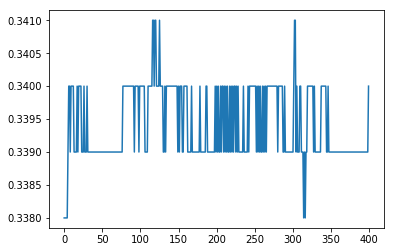

In [54]:
plt.plot(range(0,400),data_entry[:400])

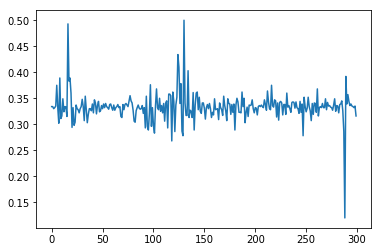

In [55]:
plt.plot(range(0,300),data_value[0:300])

In [56]:
r2_score(data_entry,data_value) #print the r2 score

-2316.9983879073716